### GMdistance_update
1. Delete all the irrelevant or depleted functions such as functions related to preparation of noise as input, optimization, reconstruction and output. Content loss should be discarded in the future as well since it is a bit redundant. 
2. Create a new function to prepare input.
3. Modified run_style_transfer. The biggest change is that there is no need to iterate runs, just six streams, so the closure function is no longer needed. 

======================================================================================================================
Until this point, the skeleton only invloves two input files, namely "style_img" and "input_img". The output generated is a floating number. The second session is the test on different pop dataset to verify the hypothesis. 

Import libraries and packages.

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.modules.module import _addindent

import copy
import os
import math

#for random feature projection
from scipy.stats import ortho_group


import soundfile as sf
from matplotlib.pyplot import figure

Original functions to prepare the input. Here, numsteps=1 since we are not training the input image. These functions will combine together in the *prepare_input* function in the next section. 

In [3]:
def log_scale(img):
    img = np.log1p(img)
    return img

def inv_log(img):
    img = np.exp(img) - 1.
    return img

In [4]:
# True uses PGHI (Truncated Gaussian window, log mag, PGHI reconstruction)
# False uses Log Mag spectrum and Griffin Lim reconstruction
tifresi=False

STYLE_FILENAME = "inputs/Pops/popb0.wav" #input filename
INPUT_FILENAME = "inputs/Pops/popc0.wav"
# You can have your output length be anything! 
SYNTHETIC_LENGTH_FACTOR = 1 # duration of generated relative to target texture

#Go up to 20000 for high quality if you are on a GPU
num_steps=1 #00 #70

####################################################################################################
#Gram matrix dot product multiplies: RFMSTACK*(feature_size/RFMSALEFACTOR)^2
RANDOM_PROJECTION= "Gaussian" # "None", "Gaussian", "Sparse"   (n=None means no random projection at all)
RFMSCALEFACTOR=16   #RM project to size relative to feature dimension
RFMSTACK=16         # how many different RMs to stack
####################################################################################################

#MS Number of separate CNNs operating on input
numStreams=6
learning_Rate= 1 #0.1 #.1  # must be smaller for more streams (if numStream=1, then learning_Rate can be 1)

In [5]:
# set filenames
outname = 'rftests' #output dir
runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

#librosa audio params
N_FFT = 512 
K_HOP = 128 

# architecture
"""use a custom convolutional network randomly initialized""" 
use01scale = False #set to true if want to scale img to [0,1] prior to training. Recommended if using VGG19
boundopt = False #whether to regularize the input within [lower,upper]. Recommended if using VGG19
whichChannel = "freq" #2d=2d conv, 1d options:freq=freq bins as channels, time= time bins as channels 
N_FILTERS = 512# 4096 #no. of filters in 1st conv layer
# hor_filter = 5 #width of conv filter, for 2d also the height of (square) kernel
possible_kernels = [2,4,8,16,64,128,256,512,1024,2048]
# possible_kernels = [2,4,8,16,32,64,128,256,512,1024,2048]
# possible_kernels = [5,5,5,5,5,5]
hor_filters = [0]*numStreams
for j in range(numStreams):
    hor_filters[j]=possible_kernels[j]

In [6]:
from tifresi.hparams import HParams
from tifresi.stft import GaussTruncTF

# from tifresi.transforms import log_spectrogram
# from tifresi.transforms import inv_log_spectrogram
#NOTE: Not using Marifioties 10 log_10 transform. Instead use natural log.
# This makes a HUGE difference !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
log_spectrogram=log_scale
inv_log_spectrogram=inv_log

stft_channels = HParams.stft_channels = N_FFT 
hop_size =  HParams.hop_size  = K_HOP
HParams.sr=16000 

# empirically set: - too small, get low-res ringing; too high, get distortion
tfresiMagSpectScale=5 # Takes the [0,1] mag spectrogram and maps it to [0, tfresiMagSpectScale]

# For faster processin, a truncated window can be used instead
stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)


In [7]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = False


In [8]:
def read_audio_spectum(filename, tifresi=True):
    #x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    x, fs  = sf.read(filename)
#    print(f'input file sample rate = {fs}')
#     x=np.append(x, np.zeros(stft_channels-np.mod(len(x), stft_channels)))
    N_SAMPLES = len(x)
#     x=x+np.random.normal(scale=.0001, size=N_SAMPLES)
#   print(f'np.mod(len(x), stft_channels) = {np.mod(len(x), stft_channels)}')
#   print(f' number of hops is {len(x)//hop_size}')
    
    if tifresi :
#       print(f'In read audio, doing tifresi spectrogram')
#         R=tfresiMagSpectScale*stft_system.spectrogram(x)
        R=stft_system.spectrogram(x)
    else :
#       print(f'In read audio, doing librosa spectrogram')
        R = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT,  center=False))    
        
#   print(f'R range is  [{np.amin(R)}, {np.amax(R)}')
#   print(f'K_HOP - {K_HOP} and N_FFT is {N_FFT}')
#   print(f'R shape is {R.shape}')
    return R, fs


def findMinMax(img):
    return int(math.floor(np.amin(img))),int(math.ceil(np.amax(img)))

def img_scale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [datasetMin,datasetMax] -> [scaleMin,scaleMax]"""    
    shift = (scaleMax-scaleMin) / (datasetMax-datasetMin)
    scaled_values = shift * (img-datasetMin) + scaleMin
#   print("img_scale: Using [{0},{1}] -> [{2},{3}] for scale conversion".format(datasetMin,datasetMax,scaleMin,scaleMax))
    return scaled_values

def img_invscale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [scaleMin,scaleMax] -> [datasetMin,datasetMax]"""
    shift = (datasetMax-datasetMin) / (scaleMax-scaleMin)
    scaled_values = shift * (img-scaleMin) + datasetMin
#   print("img_invscale: Using [{0},{1}] -> [{2},{3}] for inverse scale conversion".format(scaleMin,scaleMax,datasetMin,datasetMax))
    return scaled_values
    
#if 0
    # use below functions to use librosa db scale, normalized to [0,1]
    # note that this scaling does not work well for style transfer
    def db_scale(img,scale=80):
        img = librosa.amplitude_to_db(img)
        shift = float(np.amax(img))
        img = img - shift #put max at 0
        img = img/scale #scale from [-80,0] to [-1,0]
        img = img + 1. #shift to [0,1]
        img = np.maximum(img, 0) #clip anything below 0
        return img, shift

    def inv_db(img,shift,scale=80):
        img = img - 1. #shift from [0,1] to [-1,0]
        img = img * scale #[-1,0] -> [-80,0]
        img = img + shift
        img = librosa.db_to_amplitude(img)    
        return img

Here is the function to prepare the input. The two inputs will be pre-processed thorugh the same function. 

In [9]:
# Create a new function to prepare and inspect the inputs. 
def prepare_input(FILENAME):
    R, fs = read_audio_spectum(FILENAME, tifresi)
    print(f"raw spectrogram R range before log and scaling: [{np.amin(R)},{np.amax(R)}] ")

    if tifresi :
        a_style = log_spectrogram(R)
    else :
        a_style = log_scale(R)
    
    print(f"    LOG    range before scaling: [{np.amin(a_style)},{np.amax(a_style)}]",)
    print(f'shape of a_style is {a_style.shape}')

    if use01scale == True:
        a_min,a_max = findMinMax(a_style)
        a_style = img_scale(a_style,a_min,a_max,0,1)
    
    if 0 : #RUN PGHI ON THE ORIGINAL INPUT DATA SPECTROGRAM  - ASSUMING TFRESI for the little experiment in this cell
    # now invert it, just like we will do with the GAN-generated images

        #SPECTOFFSET
        SPECTOFFSET=0 #.25

        lspect=a_style
        print(f' shape of lspect is {lspect.shape}')
        print(use01scale)

        #ASSUMING TIFRES
        print('TIFResi: inv_log_spectrogram')
        if use01scale == True:
            out_spec = inv_log_spectrogram(lspect+ SPECTOFFSET) 
        else:
            out_spec =inv_log_spectrogram(lspect+SPECTOFFSET) 
        print(f' shape of out_spec is {out_spec.shape}')
        x = stft_system.invert_spectrogram(out_spec) 
        display(Audio(x, rate=16000, autoplay=True))

    #plt.figure(figsize=(10, 5))
    #plt.title('Style spectrogram')
    #plt.imshow(a_style, origin='lower')
    temp_a_style=a_style # for reality check in next cell

    N_SAMPLES = a_style.shape[1] #time bins
    N_FREQ = a_style.shape[0] #freq bins
    
    a_style = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]
    if whichChannel == "2d":
        a_style = torch.from_numpy(a_style) #pytorch:[batch,channels(1),height(freq),width(samples)]
    elif whichChannel == "freq":
        a_style = torch.from_numpy(a_style).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]
    elif whichChannel == "time":
        a_style = torch.from_numpy(a_style).permute(0,3,1,2) #pytorch:[batch,channels(samples),height(1),width(freq)]

    converted_img = Variable(a_style).type(dtype) #convert to pytorch variable
    return converted_img,N_SAMPLES,N_FREQ

In [10]:
style_img,N_SAMPLES,N_FREQ=prepare_input(STYLE_FILENAME)
input_img,n_SAMPLES,n_FREQ=prepare_input(INPUT_FILENAME) #create two dummy variables

raw spectrogram R range before log and scaling: [0.0,43.46055766825932] 
    LOG    range before scaling: [0.0,3.7946024516031196]
shape of a_style is (257, 247)
raw spectrogram R range before log and scaling: [0.0,28.47720488931677] 
    LOG    range before scaling: [0.0,3.3836172490307987]
shape of a_style is (257, 247)


(257, 247)
Output range: 0.0 3.7946024
mean and sigma: 0.090404764 0.30420274


<Figure size 720x360 with 0 Axes>

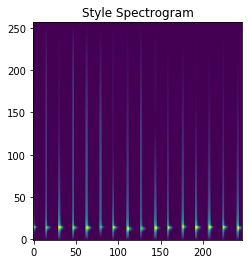

In [11]:
def imshow(tensor, n_freqs, n_samples, channels=1, title=None, origin='lower'):
    """ transforms pytorch tensor to numpy array and plots it out """
    
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    if whichChannel == "2d":
        image = image
    if whichChannel == "freq":
        image = image.permute(0,2,1,3).contiguous() # get the dimensions in proper order
    elif whichChannel == "time":
        image = image.permute(0,2,3,1).contiguous() # get the dimensions in proper order
    image = image.view(n_freqs, n_samples)  # remove the fake batch dimension
    
    image = image.numpy() #convert pytorch tensor to numpy array
    print(image.shape) #check shape
    print("Output range:",np.amin(image),np.amax(image))
    print("mean and sigma:",np.mean(image),np.std(image))
    
    
    plt.imshow(image, origin=origin)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image #return numpy array

"Just to check we can get back the numpy array with the correct shape"
plt.figure(figsize=(10, 5))
plt.figure()
_=imshow(style_img.data, N_FREQ, N_SAMPLES, title='Style Spectrogram', origin='lower')

#plt.figure()
#imshow(content_img.data, title='Content Image')

Network begins. 

In [12]:
"Here we create the custom network"
import collections as c

if whichChannel == "2d":
    IN_CHANNELS = 1
elif whichChannel == "freq":
    IN_CHANNELS = N_FREQ
elif whichChannel == "time":
    IN_CHANNELS = N_SAMPLES
    

# custom weights initialization
def weights_init(m,hor_filter):
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQ + N_FILTERS) * hor_filter))
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
        m.weight.data.normal_(0.0, std)

class style_net(nn.Module):
    """Here create the network you want to use by adding/removing layers in nn.Sequential"""
    def __init__(self,hor_filter):
        super(style_net, self).__init__()
#         self.hor_filter=hor_filter
        self.layers = nn.Sequential(c.OrderedDict([
                            ('conv1',nn.Conv2d(IN_CHANNELS,N_FILTERS,kernel_size=(1,hor_filter),bias=False)),
                            ('relu1',nn.ReLU())#,
#                             ('max1', nn.MaxPool2d(kernel_size=(1,2))),
            
#                             ('conv2',nn.Conv2d(N_FILTERS,N_FILTERS//2,kernel_size=(1,hor_filter),bias=False)),
#                             ('relu2',nn.ReLU()),
#                             ('max2', nn.MaxPool2d(kernel_size=(1,2))),
            
#                             ('conv3',nn.Conv2d(N_FILTERS//2,N_FILTERS//4,kernel_size=(1,hor_filter),bias=False)),
#                             ('relu3',nn.ReLU())
        ]))

                            #('relu2',nn.ReLU()),
                            #('max2', nn.MaxPool2d(kernel_size=(1,2))),


                            #('conv3',nn.Conv2d(N_FILTERS//2,N_FILTERS//2,kernel_size=(1,hor_filter),bias=False)),
                            #('relu3',nn.ReLU()),
                            #('max3', nn.MaxPool2d(kernel_size=(1,2))),

                            #('conv4',nn.Conv2d(N_FILTERS//2,N_FILTERS//4,kernel_size=(1,hor_filter),bias=False)),
                            #('relu4',nn.ReLU()),
                            #('max4', nn.MaxPool2d(kernel_size=(1,2))),


                            #('conv5',nn.Conv2d(N_FILTERS//4,N_FILTERS//4,kernel_size=(1,hor_filter),bias=False)),
                            #('relu5',nn.ReLU()),
                            #('max5', nn.MaxPool2d(kernel_size=(1,2))),


                            #('conv6',nn.Conv2d(N_FILTERS//4,N_FILTERS//8,kernel_size=(1,hor_filter),bias=False)),
                            #('relu6',nn.ReLU())]))

    def forward(self,input):
        out = self.layers(input)
        return out
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
cnnlist=[] 
#MS create a separate CNN for each stream
for j in range(numStreams) :
    cnn = style_net(hor_filters[j])
    cnn.apply(lambda x, f=hor_filters[j]: weights_init(x,f))
    for param in cnn.parameters():
        param.requires_grad = False
    print(list(cnn.layers))

    # move it to the GPU if possible:
    if use_cuda:
        cnn = cnn.cuda()
    
    cnnlist.append(cnn)

# Add the style/content loss 'layer' after the specified layer:
content_layers_default = [] #ignore for now
# style_layers_default = ['relu_1']
style_layers_default = ['relu_1']

[Conv2d(257, 512, kernel_size=(1, 2), stride=(1, 1), bias=False), ReLU()]
[Conv2d(257, 512, kernel_size=(1, 4), stride=(1, 1), bias=False), ReLU()]
[Conv2d(257, 512, kernel_size=(1, 8), stride=(1, 1), bias=False), ReLU()]
[Conv2d(257, 512, kernel_size=(1, 16), stride=(1, 1), bias=False), ReLU()]
[Conv2d(257, 512, kernel_size=(1, 64), stride=(1, 1), bias=False), ReLU()]
[Conv2d(257, 512, kernel_size=(1, 128), stride=(1, 1), bias=False), ReLU()]


In [13]:
class ContentLoss(nn.Module):
    """Since doing texture only we ignore this for now"""

    def __init__(self, target, weight): #weight here is the epsilon tuning (how much content vs style)
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [14]:
# create random feature projection matrix
RFM={}

# This is the "sparse" Achlioptas matrix
if RANDOM_PROJECTION=="Sparse" : 
    RFM[1024]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (1024,int(1024/RFMSCALEFACTOR)), p=[1./6.,2./3., 1./6.])).type(dtype)
    RFM[512]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (512,int(512/RFMSCALEFACTOR)), p=[1./6.,2./3., 1./6.])).type(dtype)
    RFM[256]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (256,int(256/RFMSCALEFACTOR)), p=[1./6.,2./3., 1./6.])).type(dtype)
    RFM[128]=torch.from_numpy(np.random.choice(np.sqrt(3)*np.array([1., 0., -1.]), (128,int(128/RFMSCALEFACTOR)), p=[1./6.,2./3., 1./6.])).type(dtype)

#Full orthonormal gaussian 
if RANDOM_PROJECTION=="Gaussian" : 
   # RFM[1024]=(torch.from_numpy(ortho_group.rvs(1024)[:int(1024/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)
    RFM[512]= (torch.from_numpy(ortho_group.rvs(512)[: int(512/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)
    #RFM[256]= (torch.from_numpy(ortho_group.rvs(256)[: int(256/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)
    #RFM[128]= (torch.from_numpy(ortho_group.rvs(128)[: int(128/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)
    for rm in range(1, RFMSTACK) : 
        #RFM[1024]= torch.cat( (RFM[1024], (torch.from_numpy(ortho_group.rvs(1024)[:int(1024/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)), dim=0)
        RFM[512]=torch.cat( (RFM[512],    (torch.from_numpy(ortho_group.rvs(512)[ :int(512/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)), dim=0)
        #RFM[256]=torch.cat( (RFM[256],    (torch.from_numpy(ortho_group.rvs(256)[ :int(256/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)), dim=0)
        #RFM[128]=torch.cat( (RFM[128],    (torch.from_numpy(ortho_group.rvs(128)[ :int(128/RFMSCALEFACTOR)]).type(dtype)).unsqueeze(0)), dim=0)
        


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [15]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(=1)
                                  #b=number of feature maps
                                  #(c,d)=dimensions of a feat. map (N=c*d) -> for 1D conv c=1
        #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        features = input.view(b, a * c * d)  # resise F_XL into \hat F_XL
        
       # features2=torch.matmul(RFM[:b//2,:b], features)
        if RANDOM_PROJECTION=="None":
            features2=features.unsqueeze(0)
        else :
            features2=torch.matmul(RFM[b], features)
        #print(f"In GramMatrix, shape of features = {np.shape(features2)}")

        #G = torch.matmul(features2, features2.t())  # compute the gram product #normalizing? - length of the features
        G = torch.matmul(features2, torch.transpose(features2, 1,2))  # compute the gram product #normalizing? - length of the features
        #print(f"In GramMatrix, shape of grammatrix = {np.shape(G)}")
        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * c * d)

In [16]:
#foofoo
class StyleLoss(nn.Module):

    def __init__(self, target, weight, layer): #weight here is the alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss(size_average=False)
        #print(f'Creating StyleLoss module - this one for layer {layer} with target shape {target.shape}' )


    def forward(self, input):
        #print(f' StyleLoss.forward with input of shape {input.shape}')
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target) #/sum(sum(self.target**2)) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=True)
        return self.loss

In [17]:
#rebuild network with the layers we want
def get_style_model_and_losses(cnn, style_img, content_img=None,
                               style_weight=1, content_weight=0,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default, style_img2=None):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    layer_list = list(cnn.layers)
    
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    #here we rebuild the network adding the in content and style loss "layers"   
    i = 1  
    for layer in layer_list:
        
        if isinstance(layer, nn.Conv2d): #if layer in vgg19 belong to class nn.Conv2d
            name = "conv_" + str(i)
            model.add_module(name, layer) #add that layer to our sequential model
            
            if content_img != None:
                if name in content_layers: #at the right depth add the content loss "layer"
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers: #at the right depth add the content loss "layer"
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight, name)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): #do the same for ReLUs
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if content_img != None:
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight, name)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss) 
                
            i += 1

        if isinstance(layer, nn.MaxPool2d): #do the same for maxpool
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight, name)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            #avgpool = nn.AvgPool2d(kernel_size=(1,2),
            #                stride=layer.stride, padding = layer.padding)
            #model.add_module(name, avgpool)  # *** can also replace certain layers if we want eg. maxpool -> avgpool


    #for param in model.parameters():
    #    param.requires_grad = False
    return model, style_losses,target_feature_gram

In [18]:
def run_style_transfer(cnnlist, style_img, input_img, content_img=None, num_steps=num_steps,
                       style_weight=1, content_weight=0): 
    """Run the style transfer"""
    
    #MS - one model, loss accumulator, and optimizer per stream 
    
    modelMS=[None for j in range(numStreams)]
    style_lossesMS=[None for j in range(numStreams)] 
    content_lossesMS=[None for j in range(numStreams)]


    #MS one input_param for all streams, each operating on the same data. 
    input_param = nn.Parameter(input_img.data)
    
    
    prev = input_param.data
    
    # first create the separate cnn models and losses
    for j in range(numStreams) :
        print('Building the style transfer model..')
        modelMS[j], style_lossesMS[j], content_lossesMS[j] = get_style_model_and_losses(cnnlist[j],
            style_img, content_img, style_weight, content_weight)

        print("Input range:",torch.max(input_param.data),torch.min(input_param.data))   
        print(modelMS[j])
    
    print(f'Created {j} MS models')
    # print(f' input_param[0] is input_param[1] ? ...... {input_paramMS[0] is input_paramMS[1]}')    # FALSE!    
    

    run = [0]
    
    plt.figure()
    while run[0] < num_steps:

        run[0] += 1
        print("Current Run Number = ",run[0])
        
        #MS create the closure, and then run the optimizer for each stream in sequence
        # (the update from each stream becomes the input for the next, I think!)
        print("numStreams = ",numStreams)
        #def closure():
        style_score = 0
        for j in range(numStreams) :       
            modelMS[j](input_param)                
            for sl in style_lossesMS[j]:
                style_score += sl.backward() #call backward method to grab the loss
            print("run", run[0], " stream ",j)          
            total_loss = style_score
            print("total_loss={:4f}".format(total_loss))
            
        # END MS loop
        
    return total_loss/numStreams   # Can return any of the MS input_params - they all refer to the same object

======================================================================================================================

In [31]:
# visualize the loss in two way
from mpl_toolkits.axes_grid1 import make_axes_locatable
def visualize_loss(s,l):
    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='50%', pad=0.05)
    im = ax.imshow(s, cmap='bone')
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()
    
    # plotting the loss
    plt.title("Loss graph")
    plt.ylabel("Loss")
    plt.plot(l, color ="red")
    plt.show()
    return 

======================================================================================================================

['popcf02.wav', 'popcf16.wav', 'popb2.wav', 'popb3.wav', 'popcf17.wav', 'popcf15.wav', 'popcf01.wav', 'popb1.wav', 'popb0.wav', 'popc4.wav', 'popcf00.wav', 'popcf14.wav', 'popcf10.wav', 'popcf04.wav', '.DS_Store', 'popc0.wav', 'popb4.wav', 'popc1.wav', 'popcf05.wav', 'popcf11.wav', 'popcf07.wav', 'popcf13.wav', 'popcf03wav.wav', 'popc3.wav', 'popc2.wav', 'popcf12.wav', 'popcf06.wav', 'popd1.wav', 'popd0.wav', 'popd2.wav', 'popd3.wav', 'popd7.wav', 'popd6.wav', 'popd4.wav', 'popd5.wav', '.ipynb_checkpoints', 'popcf20.wav', 'popcf08.wav', 'popcf09.wav', 'popcf19.wav', 'popcf18.wav']
input_imgs: ['inputs/Pops/popcf00.wav', 'inputs/Pops/popcf01.wav', 'inputs/Pops/popcf02.wav', 'inputs/Pops/popcf03wav.wav', 'inputs/Pops/popcf04.wav', 'inputs/Pops/popcf05.wav', 'inputs/Pops/popcf06.wav', 'inputs/Pops/popcf07.wav', 'inputs/Pops/popcf08.wav', 'inputs/Pops/popcf09.wav', 'inputs/Pops/popcf10.wav', 'inputs/Pops/popcf11.wav', 'inputs/Pops/popcf12.wav', 'inputs/Pops/popcf13.wav', 'inputs/Pops/popcf

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Input range: tensor(3.7683) tensor(0.)
Sequential(
  (conv_1): Conv2d(257, 512, kernel_size=(1, 128), stride=(1, 1), bias=False)
  (relu_1): ReLU()
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
)
Created 5 MS models
Current Run Number =  1
numStreams =  6
run 1  stream  0
total_loss=0.000000
run 1  stream  1
total_loss=0.000000
run 1  stream  2
total_loss=0.000000
run 1  stream  3
total_loss=0.000000
run 1  stream  4
total_loss=0.000000
run 1  stream  5
total_loss=0.000000
raw spectrogram R range before log and scaling: [0.0,42.30645686056237] 
    LOG    range before scaling: [0.0,3.7683017430728634]
shape of a_style is (257, 247)
raw spectrogram R range before log and scaling: [0.0,43.09821209855036] 
    LOG    range before scaling: [0.0,3.786419239647967]
shape of a_style is (257, 247)
Building the style transfer model..
Input range: tensor(3.7864) tensor(0.)
Sequential(
  (conv_1): Conv2d(257, 512, kernel_size=(1, 2), stride=(1, 1), bias=Fals

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


run 1  stream  2
total_loss=19.388672
run 1  stream  3
total_loss=21.259665
run 1  stream  4
total_loss=22.350668
run 1  stream  5
total_loss=23.400372


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

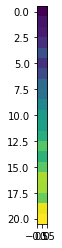

In [28]:
# samples have the same cf (00.00) and irreg (00.00), but different rate parameters
testfolder = 'inputs/Pops'
import os

input_imgs = []
loss=[]
listdir = os.listdir(testfolder)
print(listdir)
for filename in listdir:
    if 'cf' in filename:
        input_imgs.append(testfolder+'/'+filename)
    

input_imgs.sort()
print("input_imgs:",input_imgs)

styleloss_mat = np.zeros((21,1))

for i in range(len(input_imgs)):
    style_img,N_SAMPLES,N_FREQ=prepare_input(input_imgs[0])
    input_img,n_SAMPLES,n_FREQ=prepare_input(input_imgs[i]) #create two dummy variables
    styleloss_mat[i,0] = run_style_transfer(cnnlist, style_img, input_img)
    loss.append(styleloss_mat[i])
        
plt.figure()
plt.imshow(styleloss_mat)

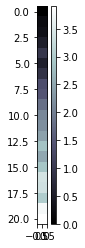

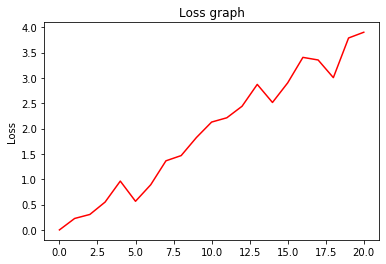

In [32]:
visualize_loss(styleloss_mat,loss)

['popcf02.wav', 'popcf16.wav', 'popb2.wav', 'popb3.wav', 'popcf17.wav', 'popcf15.wav', 'popcf01.wav', 'popb1.wav', 'popb0.wav', 'popc4.wav', 'popcf00.wav', 'popcf14.wav', 'popcf10.wav', 'popcf04.wav', '.DS_Store', 'popc0.wav', 'popb4.wav', 'popc1.wav', 'popcf05.wav', 'popcf11.wav', 'popcf07.wav', 'popcf13.wav', 'popcf03wav.wav', 'popc3.wav', 'popc2.wav', 'popcf12.wav', 'popcf06.wav', 'poprate08.wav', 'poprate09.wav', 'poprate19.wav', 'poprate18.wav', 'poprate15.wav', 'poprate01.wav', 'poprate00.wav', 'poprate14.wav', 'poprate02.wav', 'poprate16.wav', 'poprate17.wav', 'poprate03.wav', 'poprate07.wav', 'poprate13.wav', 'poprate12.wav', 'poprate06.wav', 'poprate10.wav', 'poprate04.wav', 'poprate05.wav', 'poprate11.wav', '.ipynb_checkpoints', 'popcf20.wav', 'popcf08.wav', 'popcf09.wav', 'popcf19.wav', 'popcf18.wav']
input_imgs: ['inputs/Pops/poprate00.wav', 'inputs/Pops/poprate01.wav', 'inputs/Pops/poprate02.wav', 'inputs/Pops/poprate03.wav', 'inputs/Pops/poprate04.wav', 'inputs/Pops/popra

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Input range: tensor(3.7582) tensor(0.)
Sequential(
  (conv_1): Conv2d(257, 512, kernel_size=(1, 128), stride=(1, 1), bias=False)
  (relu_1): ReLU()
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
)
Created 5 MS models
Current Run Number =  1
numStreams =  6
run 1  stream  0
total_loss=0.000000
run 1  stream  1
total_loss=0.000000
run 1  stream  2
total_loss=0.000000
run 1  stream  3
total_loss=0.000000
run 1  stream  4
total_loss=0.000000
run 1  stream  5
total_loss=0.000000
raw spectrogram R range before log and scaling: [0.0,41.871869674554475] 
    LOG    range before scaling: [0.0,3.758215892314689]
shape of a_style is (257, 247)
raw spectrogram R range before log and scaling: [0.0,43.474515293930494] 
    LOG    range before scaling: [0.0,3.794916335098593]
shape of a_style is (257, 247)
Building the style transfer model..
Input range: tensor(3.7949) tensor(0.)
Sequential(
  (conv_1): Conv2d(257, 512, kernel_size=(1, 2), stride=(1, 1), bias=Fal

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

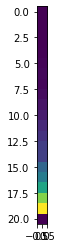

In [35]:
# samples have the same cf (00.00) and irreg (00.00), but different rate parameters
testfolder = 'inputs/Pops'
import os

input_imgs = []
loss=[]
listdir = os.listdir(testfolder)
print(listdir)
for filename in listdir:
    if 'rate' in filename:
        input_imgs.append(testfolder+'/'+filename)
    

input_imgs.sort()
print("input_imgs:",input_imgs)

styleloss_mat = np.zeros((21,1))

for i in range(len(input_imgs)):
    style_img,N_SAMPLES,N_FREQ=prepare_input(input_imgs[0])
    input_img,n_SAMPLES,n_FREQ=prepare_input(input_imgs[i]) #create two dummy variables
    styleloss_mat[i,0] = run_style_transfer(cnnlist, style_img, input_img)
    loss.append(styleloss_mat[i])
        
plt.figure()
plt.imshow(styleloss_mat)

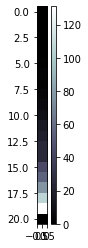

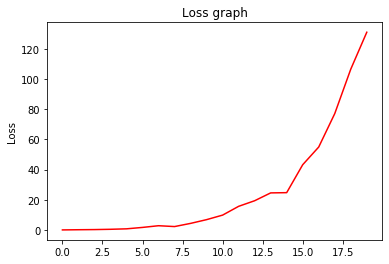

In [36]:
visualize_loss(styleloss_mat,loss)